# Lab 6 - Predicting Malignant or Benign Skin Cancer
Data from [Kaggle](https://www.kaggle.com/datasets/rm1000/skin-cancer-isic-images). A subset of [ISIC Database](https://www.isic-archive.com/).

Label

## Import Packages

In [117]:
import sys
import math
import pathlib
import numpy as np
import tensorflow as tf
from os import makedirs, listdir, path
from shutil import copyfile, move
from random import seed, random
from matplotlib import pyplot
from keras.utils import to_categorical, img_to_array
from keras.models import Sequential, load_model
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import load_img
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, Dropout
from keras.optimizers import SGD

## Load in Data

In [66]:
root = 'datasets/isic/original'
current_dir = pathlib.Path.cwd().parent
combined = current_dir / root

In [74]:
batch_size = 64 
img_height = 224
img_width = 224

In [69]:
# https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
train_ds = image_dataset_from_directory(
    combined,
    validation_split=0.3,
    subset="training",
    seed=82,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    combined,
    validation_split=0.3,
    subset="validation",
    seed=82,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3297 files belonging to 2 classes.
Using 2308 files for training.
Found 3297 files belonging to 2 classes.
Using 989 files for validation.


In [79]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Setup Utility Functions

In [107]:
# Plot diagnostic learning curves
def plot_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    pyplot.close() 
    
# Run test harness for a trained model 
def test_harness(model, epochs = 10):
    # fit model
    history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, verbose = 1)
    # evaluate model
    _, acc = model.evaluate(val_ds, steps=len(val_ds), verbose=2)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    plot_diagnostics(history)

    return model

## One Block VGG Model

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.5526 - loss: 7.3982 - val_accuracy: 0.6127 - val_loss: 0.6139
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.6613 - loss: 0.5739 - val_accuracy: 0.7412 - val_loss: 0.5535
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.7152 - loss: 0.5501 - val_accuracy: 0.7219 - val_loss: 0.5491
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.7341 - loss: 0.5148 - val_accuracy: 0.7745 - val_loss: 0.4651
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.7616 - loss: 0.4578 - val_accuracy: 0.7452 - val_loss: 0.5077
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.7239 - loss: 0.5351 - val_accuracy: 0.7685 - val_loss: 0.4836
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.7627 - loss: 0.4578 - val_accuracy: 0.7826 - val_loss: 0.4438
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.7643 - loss: 0.4450 - val_accuracy:

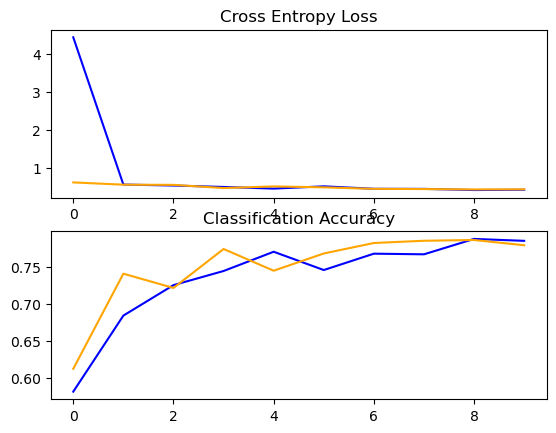

In [93]:
def one_block():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D(),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

test_harness(one_block())

## Three Block VGG Model

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 875ms/step - accuracy: 0.5286 - loss: 0.8511 - val_accuracy: 0.5763 - val_loss: 0.6657
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 846ms/step - accuracy: 0.6367 - loss: 0.6531 - val_accuracy: 0.6967 - val_loss: 0.6390
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 870ms/step - accuracy: 0.6360 - loss: 0.6406 - val_accuracy: 0.7219 - val_loss: 0.6007
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 833ms/step - accuracy: 0.6893 - loss: 0.5961 - val_accuracy: 0.7543 - val_loss: 0.5574
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 823ms/step - accuracy: 0.7380 - loss: 0.5292 - val_accuracy: 0.7583 - val_loss: 0.5437
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 812ms/step - accuracy: 0.6969 - loss: 0.5769 - val_accuracy: 0.7583 - val_loss: 0.5343
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 798ms/step - accuracy: 0.7612 - loss: 0.4894 - val_accuracy: 0.7634 - val_loss: 0.5039
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 820ms/step - accuracy: 0.7564 - loss: 0.4806 - val_accu

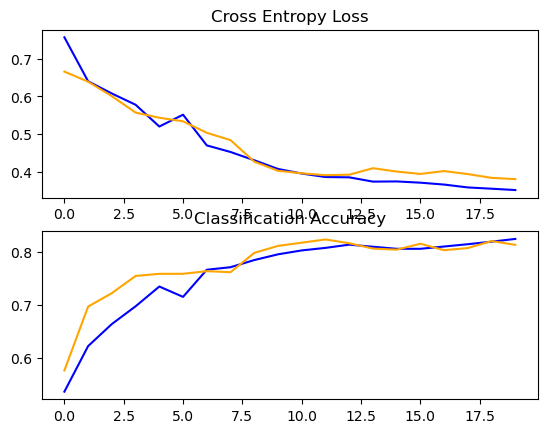

In [110]:
def three_block():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

three_save = test_harness(three_block(), 20)
three_save.save('three_block.keras')

## Three Block VGG Model with Drop

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 990ms/step - accuracy: 0.5445 - loss: 1.7710 - val_accuracy: 0.5592 - val_loss: 0.6783
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 925ms/step - accuracy: 0.5953 - loss: 0.6559 - val_accuracy: 0.7108 - val_loss: 0.6494
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 937ms/step - accuracy: 0.6918 - loss: 0.6080 - val_accuracy: 0.7219 - val_loss: 0.6166
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 909ms/step - accuracy: 0.6889 - loss: 0.5944 - val_accuracy: 0.7250 - val_loss: 0.5990
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 966ms/step - accuracy: 0.7023 - loss: 0.5835 - val_accuracy: 0.7300 - val_loss: 0.5890
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 936ms/step - accuracy: 0.7220 - loss: 0.5675 - val_accuracy: 0.7381 - val_loss: 0.5799
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 998ms/step - accuracy: 0.7250 - loss: 0.5583 - val_accuracy: 0.7381 - val_loss: 0.5688
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7413 - loss: 0.5214 - val_accurac

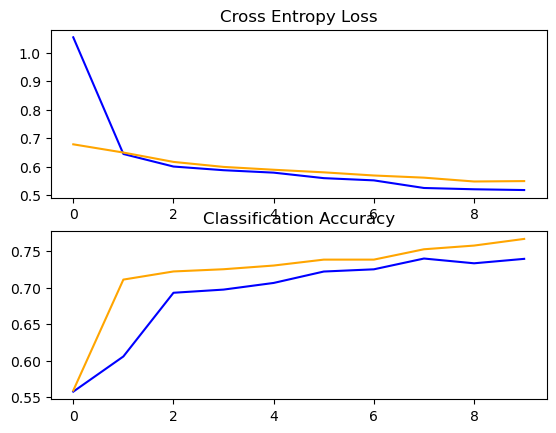

In [102]:
def three_block_drop():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

test_harness(three_block_drop(), 10)

## Four Block VGG Model with Adam optimizer 

Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5538 - loss: 5.4924 - val_accuracy: 0.4742 - val_loss: 1.3420
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6112 - loss: 0.7147 - val_accuracy: 0.6542 - val_loss: 0.8494
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7287 - loss: 0.5434 - val_accuracy: 0.8241 - val_loss: 0.4054
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7912 - loss: 0.3985 - val_accuracy: 0.7664 - val_loss: 0.4655
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7847 - loss: 0.3771 - val_accuracy: 0.8059 - val_loss: 0.3788
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8127 - loss: 0.3427 - val_accuracy: 0.8322 - val_loss: 0.3755
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8405 - loss: 0.3238 - val_accuracy: 0.7968 - val_loss: 0.4105
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8471 - loss: 0.2922 - val_accuracy: 0.7856 - val_loss:

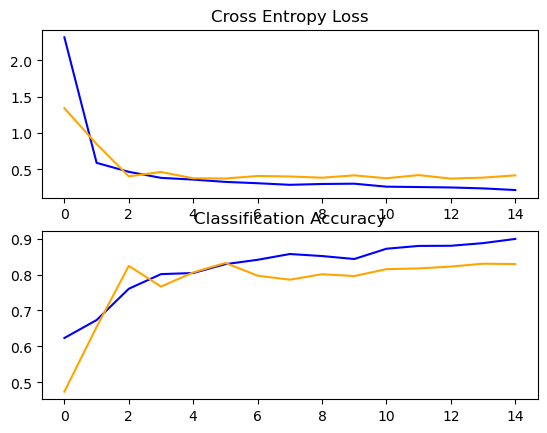

In [101]:
def four_block_adam():
    model = Sequential([
        # Rescale images to [0, 1] range
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
    	Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_initializer='he_uniform'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

test_harness(four_block_adam(), 15)

## Make Prediction

In [111]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

In [115]:
malignant = load_image('../' + root + '/malignant/1373.jpg')
benign = load_image('../' + root + '/benign/1780.jpg')

In [118]:
model = load_model('three_block.keras')

pred_mal = model.predict(malignant)
pred_ben = model.predict(benign)

print(pred_mal[0])
print(pred_ben[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.83937037]
[0.04634498]
